## Исследование методов оптимизации гиперпараметров

In [0]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch

from tqdm import tqdm

import math

import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Вспомогательные математические функции с https://github.com/mariogeiger/hessian

def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    Compute the gradient of `outputs` with respect to `inputs`
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])


def hessian(output, inputs, out=None, allow_unused=False, create_graph=False):
    '''
    Compute the Hessian of `output` with respect to `inputs`
    hessian((x * y).sum(), [x, y])
    '''
    assert output.ndimension() == 0

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    n = sum(p.numel() for p in inputs)
    if out is None:
        out = output.new_zeros(n, n)

    ai = 0
    for i, inp in enumerate(inputs):
        [grad] = torch.autograd.grad(output, inp, create_graph=True, allow_unused=allow_unused)
        grad = torch.zeros_like(inp) if grad is None else grad
        grad = grad.contiguous().view(-1)

        for j in range(inp.numel()):
            if grad[j].requires_grad:
                row = gradient(grad[j], inputs[i:], retain_graph=True, create_graph=create_graph)[j:]
            else:
                row = grad[j].new_zeros(sum(x.numel() for x in inputs[i:]) - j)

            out[ai, ai:].add_(row.type_as(out))  # ai's row
            if ai + 1 < n:
                out[ai + 1:, ai].add_(row[1:].type_as(out))  # ai's column
            del row
            ai += 1
        del grad

    return out

In [0]:
# Устанавливаем параметры для графиков

parameters = {
    'figure.figsize': (14.0, 8.0),
    'font.size': 18,
    'axes.titlesize': 24,
    'axes.labelsize': 24,
    'legend.fontsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'lines.linewidth': 2,
    'lines.markersize': 4
}

plt.rcParams.update(parameters)

In [4]:
# Создадим экземпляр вычислительной машины и посмотрим на него

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# **Эксперименты**

Проведены на простой синтетической выборке: $$x\sim \mathcal{N}(0, I_n),\ w\sim \mathcal{N}(0, I_n),\ y\sim \mathcal{N}(w^Tx, \sigma I).$$

In [0]:
# Синтезируем данные
m_samples = 256
n = 30
sigma = 0.001

w = np.random.randn(n)

X_train = np.random.randn(m_samples, n)
Y_train = (X_train @ w + sigma * np.random.randn(m_samples)).reshape([-1, 1])

X_test = np.random.randn(m_samples, n)
Y_test = (X_test @ w + sigma * np.random.randn(m_samples)).reshape([-1, 1])

X_eval = np.random.randn(m_samples, n)
Y_eval = (X_eval @ w + sigma * np.random.randn(m_samples)).reshape([-1, 1])

In [0]:
# Загружаем данные на машину
train_data = TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(Y_train).to(device))
test_data = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))
eval_data = TensorDataset(torch.Tensor(X_eval).to(device), torch.Tensor(Y_eval).to(device))

X_tr, Y_tr = train_data[:]
X_ts, Y_ts = test_data[:]
X_vl, Y_vl = test_data[:]

Модель --- MLP (полносвязная нейросеть) с одним скрытым слоем и разным количеством нейронов на нём.

In [0]:
class MLP1(torch.nn.Module):
    def __init__(self, input_dim=30, hidden_dim=5, output_dim=1, device='сpu'):
        super(MLP1, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.device = device

        self.body = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.hidden_dim),
            torch.nn.LeakyReLU(),
        )
        
        self.head = torch.nn.Linear(self.hidden_dim, self.output_dim)
        
        list_w = []
        for w in self.parameters():
            list_w.append(w.data.view(-1))
        self.parameters_num = len(torch.cat(list_w).view(-1))

        list_hyperparameters = []
        for w in self.parameters():
            list_hyperparameters.append(torch.ones_like(w.data, requires_grad=True))
        self.hyperparameters = list_hyperparameters

        self.to(device)

    def predict(self, input):
        return self.head(self.body(input))
    
    def log_prior_w(self, w, h):
        sigma = 1.
        w = w.view(-1)
        h = h.view(-1)
        return -0.5 * torch.dot(w * (h * h), w)
      
    def log_prior_all(self):
        temp = 0
        for w, h in zip(self.parameters(), self.hyperparameters):
            temp += self.log_prior_w(w, h)
        return temp
     
    def log_likelihood(self, batch_x, batch_y):
        beta = 1.
        batch_size = len(batch_y)
        return -0.5 * beta * torch.mean((self.predict(batch_x) - batch_y)**2)
    
    def margin_log_likelihood(self, batch_x, batch_y):
        return self.log_prior_all() + self.log_likelihood(batch_x, batch_y)
    
    def batch_loss(self, batch_x, batch_y):
        return torch.mean((self.predict(batch_x) - batch_y)**2)
    
    def random_h_init(self):
        for h in self.hyperparameters:
            h.data = torch.rand_like(h.data)

    def h_zero_grad(self):
        for h in self.hyperparameters:
            h.grad.zero_()

    def h_set_grad(self, grad):
        bias = 0
        for h in self.hyperparameters:
            h_size = torch.tensor(h.size()).prod()
            h.grad = grad[bias:bias+h_size].view_as(h)
            bias+=h_size
            
    def h_set_data(self, data):
        bias = 0
        for h in self.hyperparameters:
            h_size = torch.tensor(h.size()).prod()
            h.data = data[bias:bias+h_size].view_as(h)
            if h.grad is not None:
                h.grad.zero_()
            bias+=h_size

### Случайный поиск

In [0]:
def get_hyperparameters(model):
    list_hyperparameters = []
    for h in model.hyperparameters:
        list_hyperparameters.append(h.data.cpu().numpy().reshape(-1))

    return np.hstack(list_hyperparameters)

def get_Q_theta_star_hyp(model, hyperparameters, epochs_num=200):
    model.__init__(model.input_dim, model.hidden_dim, model.output_dim, model.device)
    model.h_set_data(hyperparameters)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs_num):
        generator = DataLoader(train_data, batch_size=64, shuffle=True)
        for batch_x, batch_y in generator:
            model.zero_grad()
            loss = -model.margin_log_likelihood(batch_x, batch_y)
            loss.backward()
            optimizer.step()
            
    return get_hyperparameters(model), model.batch_loss(X_vl, Y_vl).item()

In [0]:
def random_search(model, search_iterations=100, progress=list):
    hyperparam_list = []
    loss_list = []

    for iteration in progress(range(search_iterations)):
        h = torch.rand(model.parameters_num)
        h, Q_loss = get_Q_theta_star_hyp(model, h)

        hyperparam_list.append(h)
        loss_list.append(Q_loss)

    return np.array(hyperparam_list), np.array(loss_list)

In [0]:
model = MLP1(input_dim=n, output_dim=1, hidden_dim=3, device='cpu')

In [73]:
%%time
hyperparam_random_list, loss_random_list = random_search(model, 100, progress=tqdm)

100%|██████████| 100/100 [02:50<00:00,  1.70s/it]

CPU times: user 2min 43s, sys: 4.09 s, total: 2min 47s
Wall time: 2min 50s


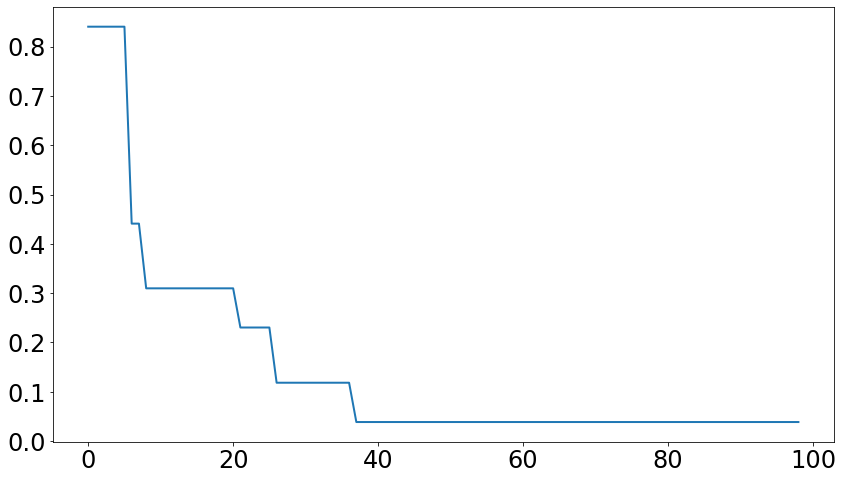

In [74]:
plot_random = plt.plot([np.min(loss_random_list[:i]) for i in range(1, len(loss_random_list))])

In [75]:
best_hyperparam_index = np.argmin(loss_random_list)
best_hyperparam_random = hyperparam_random_list[best_hyperparam_index]
best_loss_random = loss_random_list[best_hyperparam_index]
print("Best hyperparameters: ", best_hyperparam_random, '\nBest loss: ', best_loss_random)

Best hyperparameters:  [0.8223529  0.13897443 0.5172385  0.7246452  0.39426118 0.89286244
 0.01819992 0.25721592 0.27777874 0.05506861 0.3791024  0.42255908
 0.0999794  0.48997074 0.3517642  0.9700216  0.6178677  0.21881199
 0.44191122 0.65396786 0.8275141  0.54021794 0.85979927 0.40254724
 0.2767822  0.8732708  0.7685277  0.60523707 0.797754   0.3647371
 0.29484642 0.7884257  0.892275   0.8367755  0.07836759 0.42893165
 0.6952153  0.7285997  0.00335538 0.92840403 0.69815576 0.92623484
 0.9636277  0.6684118  0.38887572 0.71943694 0.04856282 0.6031436
 0.5894586  0.3311621  0.6107484  0.05840105 0.81082255 0.08060503
 0.7555133  0.20389217 0.12280691 0.6780635  0.37815368 0.27011532
 0.8402166  0.6381624  0.10013801 0.19790173 0.7237755  0.08716601
 0.5590276  0.67895055 0.05127114 0.18638551 0.9457666  0.7531027
 0.74579453 0.6336791  0.83143103 0.7284878  0.5439864  0.7565152
 0.45474476 0.28763342 0.9696786  0.8740537  0.4543907  0.9282493
 0.76369804 0.03422958 0.23210508 0.56258273

### Гауссовский процесс

In [14]:
!pip install pyGPGO

In [0]:
from pyGPGO.covfunc import squaredExponential
from pyGPGO.acquisition import Acquisition
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO
from pyGPGO.covfunc import matern32

In [17]:
model = MLP1(input_dim=n, output_dim=1, hidden_dim=3, device='cpu')
parameters_num = model.parameters_num

parameters_dict = {}
for i in range(parameters_num):
    parameters_dict['h'+str(i)] = ('cont', [0, 1])
print(parameters_num, " continuous parameters in range 0..1")

97  continuous parameters in range 0..1


In [0]:
def f(**argv):
    x = []
    for par in argv:
        x.append(argv[par])
    if not torch.is_tensor(x):
        x = torch.tensor(x)
    return -get_Q_theta_star_hyp(model, x)[1]  # знак минус, потому что в библиотеке максимизация

In [19]:
%%time
sexp = matern32()
gauss_process = GaussianProcess(sexp, optimize=True, usegrads=True)
acquis = Acquisition(mode='ExpectedImprovement')

np.random.seed(42)
gpgo = GPGO(gauss_process, acquis, f, parameters_dict)
gpgo.run(max_iter=10)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643
 0.43194502 0.29122914 0.61185289 0.13949386 0.29214465 0.36636184
 0.45606998 0.78517596 0.19967378 0.51423444 0.59241457 0.04645041
 0.60754485 0.17052412 0.06505159 0.94888554 0.96563203 0.80839735
 0.30461377 0.09767211 0.68423303 0.44015249 0.12203823 0.49517691
 0.03438852 0.9093204  0.25877998 0.66252228 0.31171108 0.52006802
 0.54671028 0.18485446 0.96958463 0.77513282 0.93949894 0.89482735
 0.59789998 0.92187424 0.0884925  0.19598286 0.04522729 0.32533033
 0.38867729 0.27134903 0.82873751 0.35675333 0.28093451 0.54269608
 0.14092422 0.80219698 0.07455064 0.98688694 0.77224477 0.19871568
 0.00552212 0.81546143 0.70685734 0.72900717 0.77127035 0.07404465
 0.35846573 0.11586906 0.86310343 0.62329813 0.33089802 0.0635

In [0]:
loss_gauss_list = -np.array(gpgo.history)

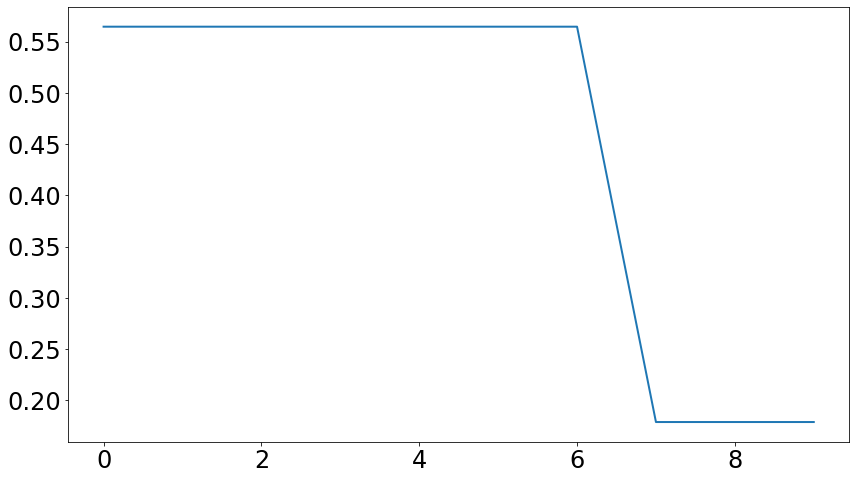

In [21]:
plot_gauss = plt.plot([np.min(loss_gauss_list[:i]) for i in range(1, len(loss_gauss_list))])

In [22]:
best_hyperparam_gauss, best_loss_gauss = gpgo.getResult()[0], -gpgo.getResult()[1]
hyperparameters_list = []
for key in best_hyperparam_gauss:
    hyperparameters_list.append(best_hyperparam_gauss[key])
    
best_hyperparam_gauss = np.array(hyperparameters_list)
print("Best hyperparameters: ", best_hyperparam_gauss, '\nBest loss: ', best_loss_gauss)

Best hyperparameters:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
 -8.67361738e-19  1.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
  

### Жадная оптимизация

In [0]:
def greedy_optimization(model, epochs=100, progress=list):
    hyperparam_list = []
    loss_list = []

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    optimizer_h = torch.optim.Adam(model.hyperparameters, lr=0.01)

    for epoch in progress(range(epochs)):
        model.zero_grad()
        model.h_zero_grad()
        loss = -model.margin_log_likelihood(X_tr, Y_tr)
        loss.backward()
        optimizer.step()

        model.zero_grad()
        model.h_zero_grad()
        loss = model.margin_log_likelihood(X_tr, Y_tr)
        loss.backward()
        optimizer_h.step()

        hyperparam_list.append(get_hyperparameters(model))
        loss_list.append(model.batch_loss(X_vl, Y_vl).item())

    return np.array(hyperparam_list), np.array(loss_list)

In [70]:
%%time
hyperparam_greedy_list, loss_greedy_list = greedy_optimization(model, 100000, progress=tqdm)

100%|██████████| 100000/100000 [06:04<00:00, 274.49it/s]

CPU times: user 5min 40s, sys: 9.41 s, total: 5min 49s
Wall time: 6min 4s


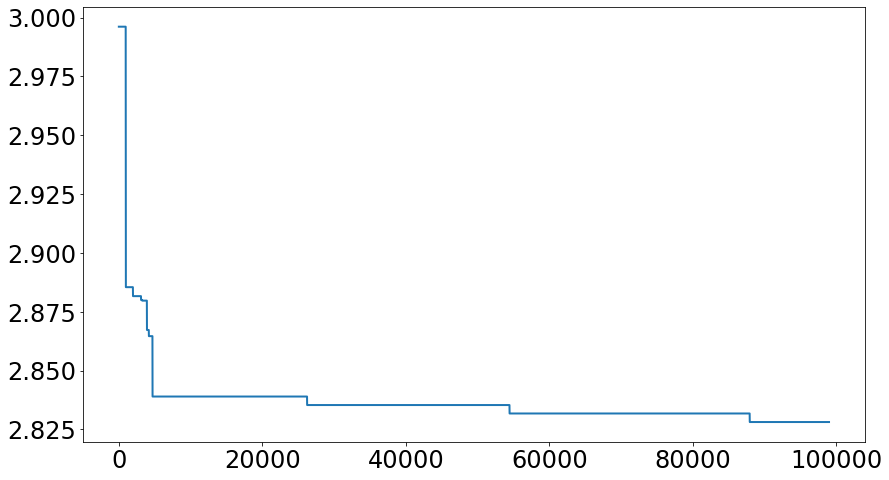

In [71]:
plot_greedy = plt.plot([np.min(loss_greedy_list[:i]) for i in range(1000, len(loss_greedy_list))])

In [72]:
best_hyperparam_index = np.argmin(loss_greedy_list)
best_hyperparam_greedy = hyperparam_greedy_list[best_hyperparam_index]
best_loss_greedy = loss_greedy_list[best_hyperparam_index]
print("Best hyperparameters: ", best_hyperparam_greedy, '\nBest loss: ', best_loss_greedy)

Best hyperparameters:  [   0.       432.05847  448.40985    0.       464.03735    0.
  421.12088 -438.33868  421.9369     0.         0.         0.
  443.6036     0.         0.       438.74945  438.05142    0.
  442.28348  475.745      0.         0.       429.57706  425.47177
    0.         0.       448.1123     0.       436.97122    0.
  681.00653  746.4511   686.0788     0.       873.423      0.
    0.         0.       788.53217  666.2002     0.       710.2868
    0.       758.3721   808.25806    0.         0.         0.
  737.27747  933.7243     0.       681.0155     0.         0.
  830.96985    0.       678.7943   789.7889     0.       704.5522
    0.       732.39276    0.         0.       829.4032   693.5756
  727.56104    0.       764.3873     0.       684.5017   703.1458
    0.       720.6841     0.       743.489      0.         0.
  748.7508   854.7857     0.         0.         0.       789.0863
  768.2443     0.         0.       757.3633   697.32654    0.
    0.         0.     

### Выводы

В качестве гиперпараметров использованы коэффициенты $L_2$-регуляризации (свой регуляризатор для каждого параметра модели).

Гауссовский процесс работает очень долго и практически сразу начинает перебирать угловые точки заданного гиперкуба ограничений. Хотя, как видно из графиков, после равного количества итераций --- 10 --- его результаты наилучшие. 

Случайный поиск работает намного быстрее и поэтому обгоняет гауссовский процесс по качеству, выполняя значительно большее число итераций за меньшее время. При этом значения гиперпараметров в наилучшем случае не имеют тенденции к уходу на границы.

Жадная оптимизация показывает наихудшие результаты даже при большом количестве итераций и является неустойчивой. Также можно увидеть, что часть гиперпараметров оказалась равной нулю, а часть принимает очень большие значения. Это может свидетельствовать о переобучении.

С другой стороны, результаты обучения с помощью гауссовских процессов и путём жадной оптимизации позволяют заметить, что для одних параметров регуляризация <<выключается>>, а для других --- наоборот, максимальна, что должно привести к обнулению соответствующего параметра.

Если бы <<выключались>> одни и те же параметры для обоих методов, можно было бы утверждать, что при данной реализации случайных выборок эти параметры незначимы, но выключение больше похоже на случайное: большого количества совпадений не обнаружено.

#### Заключение

Наилучшие результаты показал случайный поиск, однако результаты работы гауссовского процесса и жадной оптимизации поддаются интерпретации. Проигрыш гауссовского процесса связан с большими затратами времени.

